**1. Make classification data and get it ready**

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42 # Keep random state so we get the same values
                    )

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


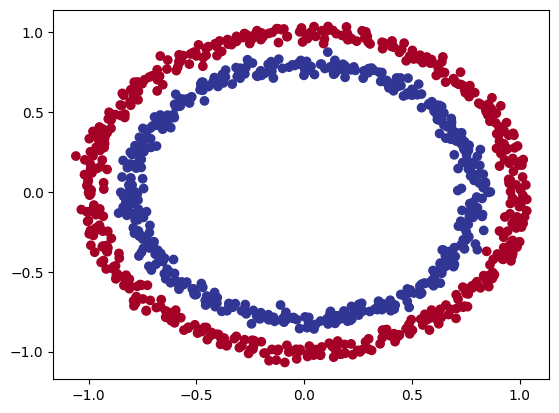

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Let's find out how we could build a PyTorch neural network to classify dots into red (0) and blue (1).

In [6]:
# Check the shapes of our features and labels

X.shape, y.shape

((1000, 2), (1000,))

**1.1 Turn data into tensors and create train and test splits**

Let's prepare the data for being used with PyTorch and for modelling. Specifically, we'll need to:

1.   Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).



In [7]:
# Turn data into tensors, otherwise this causes issues with computations later on

import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Now our data is in tensor format, let's split it into training and test sets.

In [8]:
# Split data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

**2. Building a model**

In [9]:
import torch
from torch import nn # nn stands for neural network and this package contains the building blocks for creating neural networks in Pytorch)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [10]:
# Construct a model class that subclasses nn.Module
class CircleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # Computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

self.layer_1 takes 2 input features in_features=2 and produces 5 output features out_features=5. This is known as having 5 hidden units or neurons. This layer turns the input data from having 2 features to 5 features.

Why do this?

This allows the model to learn patterns from 5 numbers rather than just 2 numbers, potentially leading to better outputs. I say potentially because sometimes it doesn't work. The number of hidden units or neuron you can use in neural network layers is a hyperparameter (a value you can set yourself) and there's no set in stone value you have to use.

You can also do the same as above using **nn.Sequential**. It performs a forward pass computation of the input data through the layers in the order they appear.

In [11]:
# Replicate CircleModelV0 with nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

This implementation looks much simpler than **subclassing nn.Module**, why not just always use nn.Sequential?

**nn.Sequential** is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order. So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom **nn.Module** subclass.

Now, we've got a model, let's see what happens when we pass some data through it.

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4175],
        [0.4026],
        [0.3490],
        [0.4374],
        [0.1782],
        [0.1704],
        [0.2638],
        [0.2090],
        [0.3563],
        [0.3997]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


**2.1 Setup loss function and optimizer**

In [13]:
# loss also called a criterion or cost function.

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = has built-in sigmoid but BCELoss = no built-in sigmoid

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

**3. Train model**

In [15]:
# View the first 5 outputs of the forward pass on the test data

y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4175],
        [0.4026],
        [0.3490],
        [0.4374],
        [0.1782]], device='cuda:0', grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random. But what are they? They are the output of our forward() method.
Which implements two layers of nn.Linear() which internally calls the following rquation:

y = input . (weights)^T + bias

The raw outputs (unmodified) of this equation and in turn, the raw outputs of our model are often referred to as **logits**. However, these numbers are hard to interpret. We'd like some numbers that are comparable to our truth labels. To get our model's raw outputs (logits) into such a form, we can use the **sigmoid activation function**.




In [16]:
# Use sigmoid on model logits

y_pred_porbs = torch.sigmoid(y_logits) # Prediction probabilities
y_pred_porbs

tensor([[0.6029],
        [0.5993],
        [0.5864],
        [0.6076],
        [0.5444]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Okay, it seems like the outputs now have some kind of consistency (even though they're still random). They're now in the form of **prediction probabilities**, in other words, the values are now how much the model thinks the data point belongs to one class or another. In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1. So these values can be viewed as a decision boundary. The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [17]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_porbs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds, y_pred_labels
print(f"y_preds without squeeze: {y_preds}")
print(f"y_pred_labels without squeeze: {y_pred_labels}")
# Get rid of extra dimension
y_preds.squeeze(), y_pred_labels.squeeze()

tensor([True, True, True, True, True], device='cuda:0')
y_preds without squeeze: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)
y_pred_labels without squeeze: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)


(tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>))

**3.2 Building a training and testing loop**

In [18]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Build training and evaluation loop
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra '1' dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> prediction probabilities -> prediction labels

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70536, Accuracy: 50.00% | Test loss: 0.70570, Test acc: 50.00%
Epoch: 10 | Loss: 0.69693, Accuracy: 50.00% | Test loss: 0.69738, Test acc: 50.00%
Epoch: 20 | Loss: 0.69429, Accuracy: 50.00% | Test loss: 0.69469, Test acc: 50.00%
Epoch: 30 | Loss: 0.69347, Accuracy: 50.00% | Test loss: 0.69384, Test acc: 50.00%
Epoch: 40 | Loss: 0.69321, Accuracy: 50.00% | Test loss: 0.69358, Test acc: 50.00%
Epoch: 50 | Loss: 0.69312, Accuracy: 51.75% | Test loss: 0.69352, Test acc: 52.50%
Epoch: 60 | Loss: 0.69309, Accuracy: 54.37% | Test loss: 0.69353, Test acc: 50.00%
Epoch: 70 | Loss: 0.69307, Accuracy: 52.00% | Test loss: 0.69356, Test acc: 48.00%
Epoch: 80 | Loss: 0.69306, Accuracy: 51.88% | Test loss: 0.69361, Test acc: 49.00%
Epoch: 90 | Loss: 0.69305, Accuracy: 51.88% | Test loss: 0.69365, Test acc: 47.50%


**4. Make predictons and evaluate the model**

From the metrics it looks like our model is random guessing. How could we investigate this further? I've got an idea. The data explorer's motto! "Visualize, visualize, visualize!" Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.


In [19]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")

else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

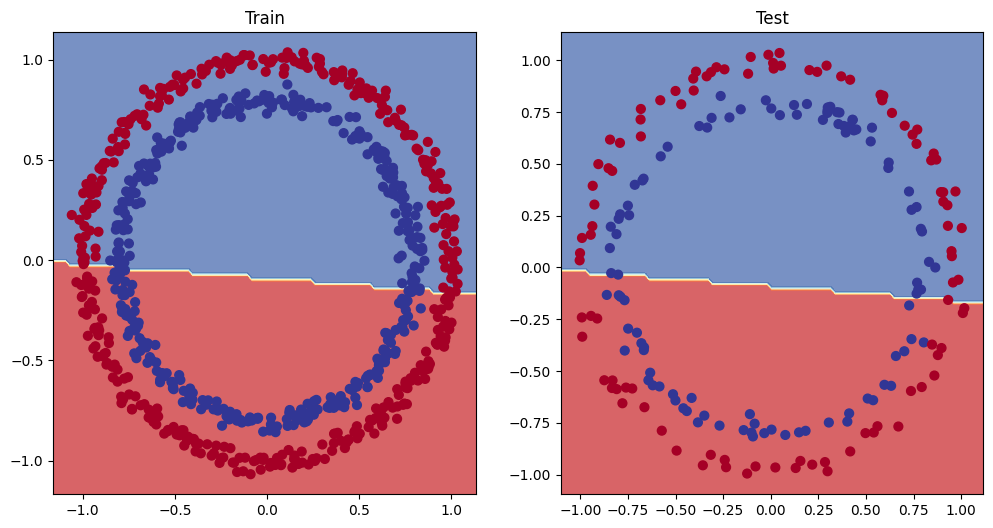

In [20]:
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

It seems like we've found the cause of model's performance issue. It's currently trying to split the red and blue dots using a straight line. That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle. In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data. **How could we improve this?**

**5. Improving a model (from a model perspective)**

Focusing specifically on the model (not the data), there are a few ways we could do this:

1. Add more layers
2. Add more hidden units / neuron
3. Fitting for longer (more epochs)
4. Changing the activation function
5. Change the learning rate
6. Change the loss function
7. Use transfer learning



Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.

In [21]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [23]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction label
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


What? our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing. Let's visualize.

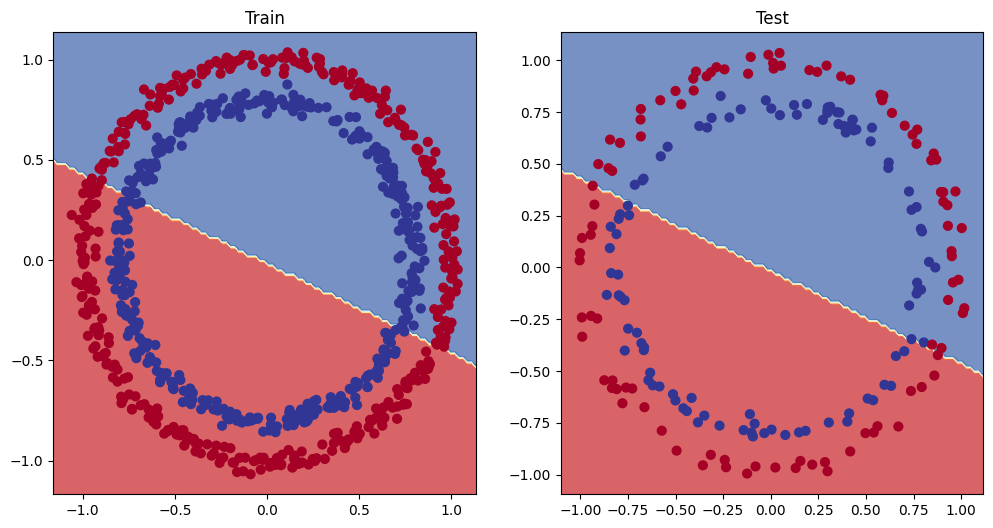

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

**5.1 Building a model with non-linerity**

In [25]:
# Build model with non-linear activation function

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        return z

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

**5.2 Training a model with non-linearity**

In [27]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction label
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test loss: 0.62145, Test acc: 79.00%


**5.3 Evaluating a model trained with non-linear activation functions**

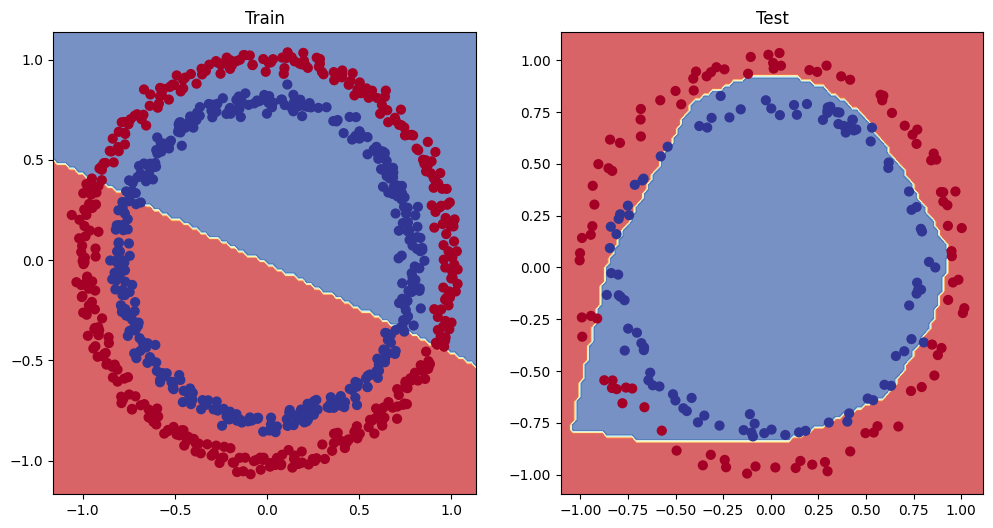

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

**6. Building a multi-class PyTorch model**

**6.1 Creating multi-class classification data**

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


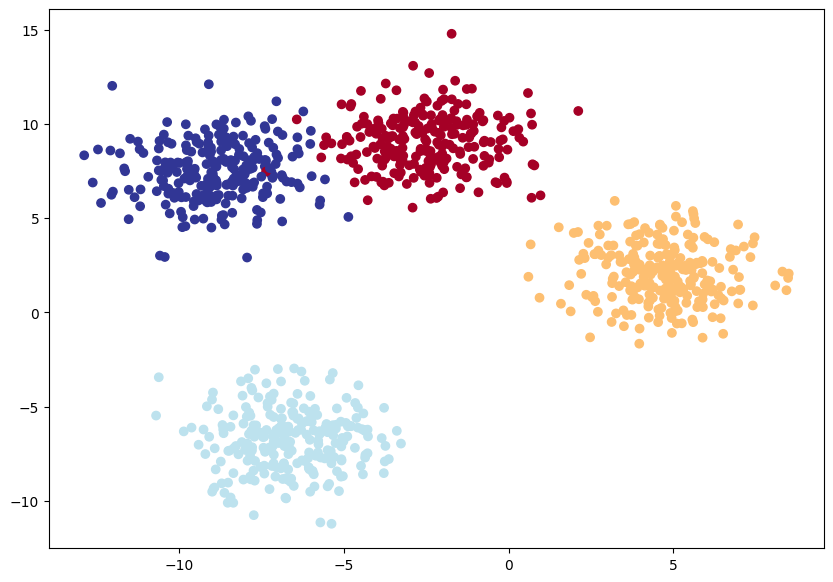

In [29]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data curation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])


# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


**6.2 Building a multi-class classification model in PyTorch**

In [30]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

**6.3 Creating a loss function and optimizer for a multi-class PyTorch model**

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

**6.4 Getting prediction probabilities for a multi-class PyTorch model**

In [32]:
# Perform a single forward pass on the data to see if it works
model_4_logits = model_4(X_blob_train.to(device))[:5]
model_4_logits

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

It looks like we get one value per feature of each sample. Let's check the shape to confirm.

In [33]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device)).shape, NUM_CLASSES

(torch.Size([800, 4]), 4)

Wonderful, our model is predicting one value for each class that we have.

In [34]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to). Let's check.

In [35]:
# Sum of the first sample output of the softmax activation function

torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to. We can check which index has the highest value using torch.argmax().

In [36]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

**6.5 Creating a training and testing loop for a multi-class PyTorch model**

In [37]:
torch.manual_seed(42)

epochs = 100

# Put the data to target device

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction label
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


**6.6 Making and evaluating predictions with a PyTorch multi-class model**

In [38]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test).squeeze()

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

Alright, looks our model's predictions are still in logit form. Though to evaluate them, they'll have to be in the same form as our labels (y_blob_test) which are in integer form. Let's convert our model's prediction logits to prediction probabilities (using torch.softmax()) then to prediction labels (by taking the argmax() of each sample).

It's possible to skip the **torch.softmax()** function and go straight from **predicted logits -> Predicted labels** by calling **torch.argmax()** directly on the logits. For example,

**y_preds = torch.argmax(y_logits, dim=1)**, this saves a computation step (no **torch.softmax()**) but results in no prediction probabilities being available to use.

In [39]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)


# Compare the first 10 model predictions and test labels
# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%



Nice! Our model predictions are now in the same form as our test labels.

Let's visualize them with plot_decision_boundary(), remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (plot_decision_boundary() does this automatically for us).

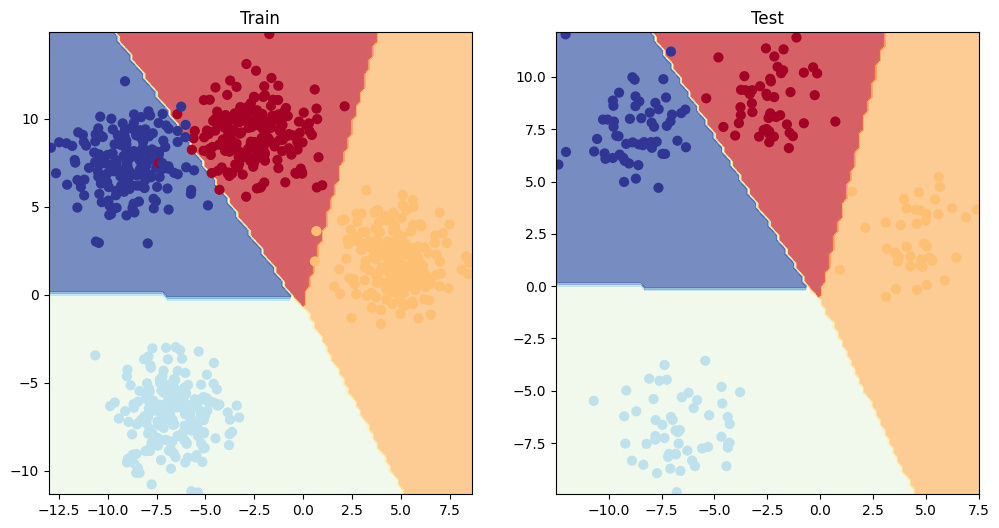

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)